In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import copy
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pickle
import matplotlib.ticker as mticker
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

df_list = df_symptoms_chunks_data
y_df = pd.read_csv('/content/drive/MyDrive/Covid files/y_df.csv')
y_df

# Encode the 'class' column as integers
le = LabelEncoder()
y_df = le.fit_transform(y_df)

# Convert the target variable to integers
y_df = y_df.astype(int)


y_df_list = []
c=0
for i in range(len(df_list)):
  yy = y_df[c:c+len(df_list[i])]
  y_df_list.append(yy)
  c+=len(df_list[i])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import accuracy_score
import warnings
from scipy import sparse

def train_xgboost(df_list,y_df_list,fs_masks=None,retrain=False):
  booster = None
  acc=[]
  f1s=[]
  precisions =[]
  recalls=[]
  aucs=[]
  y_pred = []
  y_true = []
  results=[]
  for i in range(len(df_list)):
    if retrain:
      booster = None
    # Define your data and masks
    X = df_list[i].values
    # Define your labels
    y = y_df_list[i]
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

    if fs_masks != None :
      masks_train = [fs_masks[i]]*len(X_train)
      masks_val = [fs_masks[i]]*len(X_val)
      masks_test = [fs_masks[i]]*len(X_test)


      # Apply masks to input data
      X_train_masked = X_train * masks_train
      X_val_masked = X_val * masks_val
      X_test_masked = X_test * masks_test
    else:
      X_train_masked = X_train
      X_val_masked = X_val
      X_test_masked = X_test


    # Convert masked data to sparse matrix
    X_train_sparse = sparse.csr_matrix(X_train_masked)
    X_val_sparse = sparse.csr_matrix(X_val_masked)
    X_test_sparse = sparse.csr_matrix(X_test_masked)



    # eval_set = [(X_train, y_train), (X_val, y_val)]
    # eval_metric = ["mlogloss",'merror']
    dtrain = xgb.DMatrix(X_train_sparse, label=y_train)
    dval = xgb.DMatrix(X_val_sparse, label=y_val)
    dtest = xgb.DMatrix(X_test_sparse)
    params = {'objective': 'multi:softmax', 'max_depth': 3,'num_class': 4,"eval_metric": ['merror']}
    evals_result = {}
    # Train XGBoost model on masked data
    booster = xgb.train(params, dtrain, xgb_model=booster,evals=[(dtrain,'train'),(dval,'val')], verbose_eval=False,evals_result=evals_result)
    # print(booster.get_score(importance_type='gain'))

    # Make predictions on masked test data
    preds = booster.predict(dtest)
    y_pred.append(preds)
    y_true.append(y_test)
    print(len(y_true))

    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, preds)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    acc.append(accuracy)
    print(np.mean(acc))

    # Calculate F1 score
    f1 = f1_score(y_test, preds, average='weighted')
    f1s.append(f1)

    # Calculate precision
    precision = precision_score(y_test, preds, average='weighted')
    precisions.append(precision)

    # Calculate recall
    recall = recall_score(y_test, preds, average='weighted')
    recalls.append(recall)
    # Calculate AUC
    # auc = roc_auc_score(y_true, y_pred)

    # Binarize the true labels
    y_true_binarized = label_binarize(y_test, classes=np.unique(y_test))

    # Calculate AUC for each class
    n_classes = len(np.unique(y_test))
    auc_scores = []

    for j in range(n_classes):
        y_true_j = y_true_binarized[:, j]     # True labels for class i
        y_pred_j = (preds == j).astype(int)  # Predicted labels for class i
        auc_j = roc_auc_score(y_true_j, y_pred_j)
        wighted_auc_j = ((preds==j).sum()/len(preds)) * auc_j
        auc_scores.append(auc_j)

    # Average the AUC scores
    mean_auc = np.mean(auc_scores)
    aucs.append(mean_auc)


    epochs = len(evals_result['train']['merror'])
    x_axis = range(0, epochs)

    fig, ax = plt.subplots()
    ax.plot(x_axis, np.array([1] * epochs) -np.array(evals_result['train']['merror']), label='Train')
    ax.plot(x_axis, np.array([1] * epochs)-np.array(evals_result['val']['merror']), label='valid')
    ax.legend()
    plt.xlabel('epoch')
    plt.ylabel('ACC')
    plt.title(f'XGBoost Accuracy chunk {i+1}')
    # plt.savefig(f'ss {i+1}.jpg')
    plt.show()
    results.append((np.array([1] * epochs) -np.array(evals_result['train']['merror']),np.array([1] * epochs)-np.array(evals_result['val']['merror'])))
  return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array(precisions),np.array(recalls),np.array(aucs)

1
Accuracy: 87.70%
0.8770491803278688


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


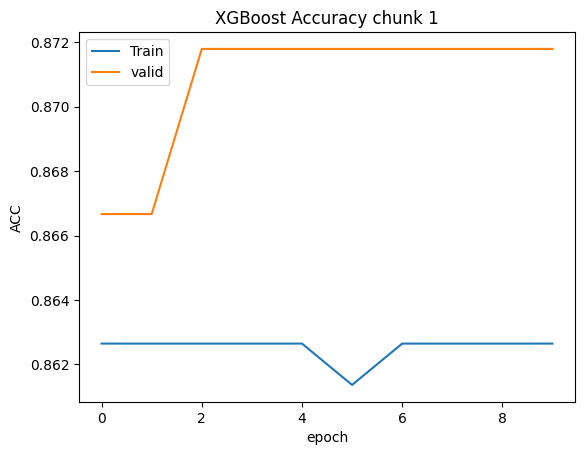

2
Accuracy: 43.69%
0.6569899020069617


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


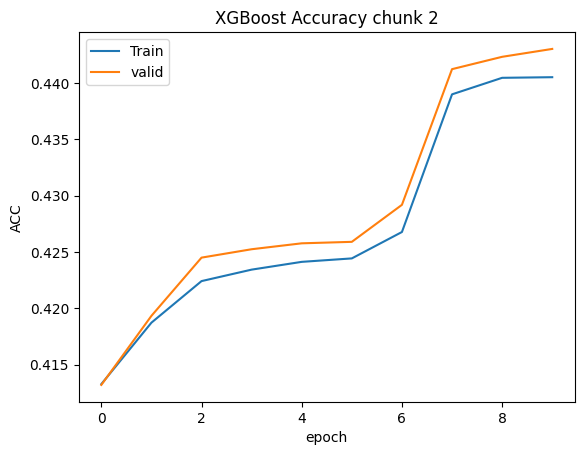

3
Accuracy: 56.87%
0.6275575763402805


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


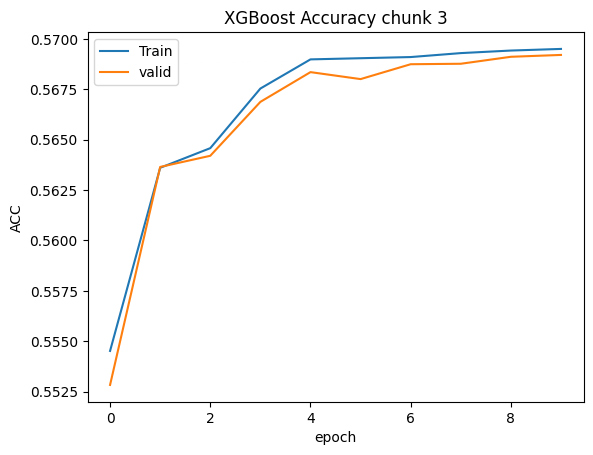

4
Accuracy: 56.72%
0.6124695386601036


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


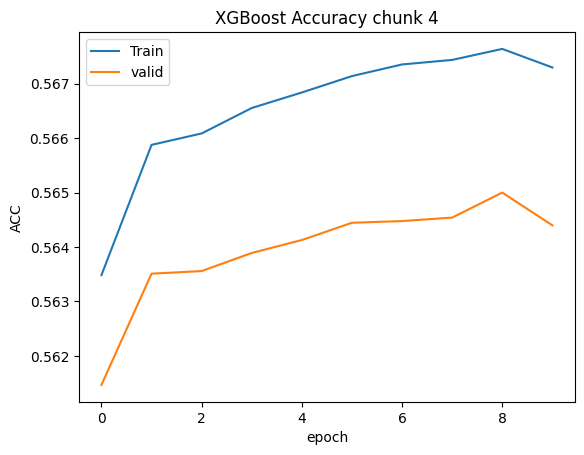

5
Accuracy: 54.43%
0.5988390689157571


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


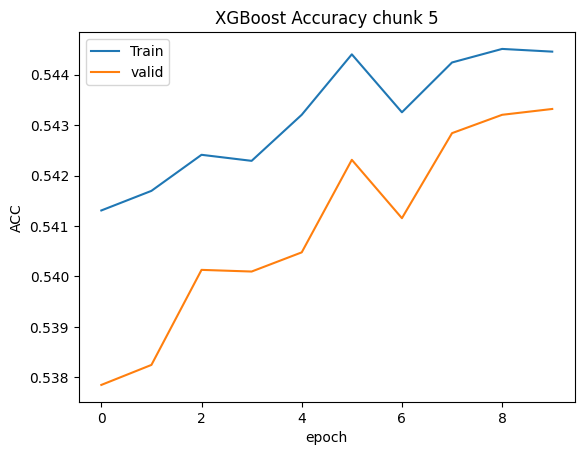

6
Accuracy: 61.13%
0.6009077764974456


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


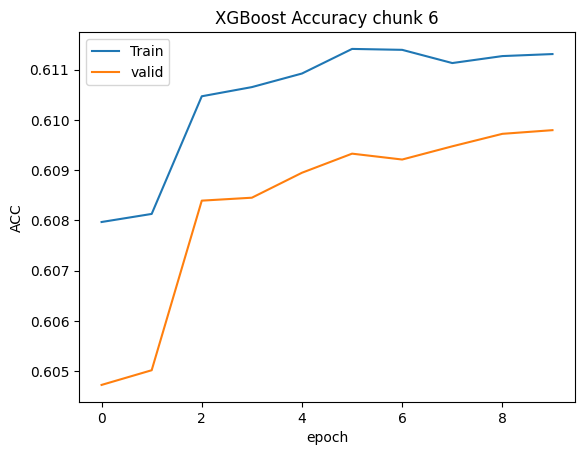

7
Accuracy: 74.94%
0.622121289550594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


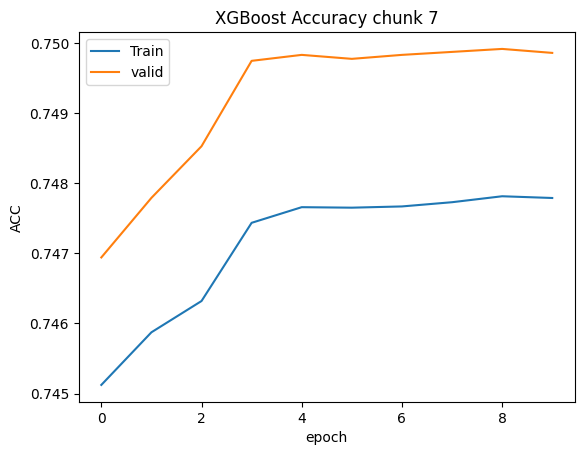

8
Accuracy: 71.92%
0.6342591509758334


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


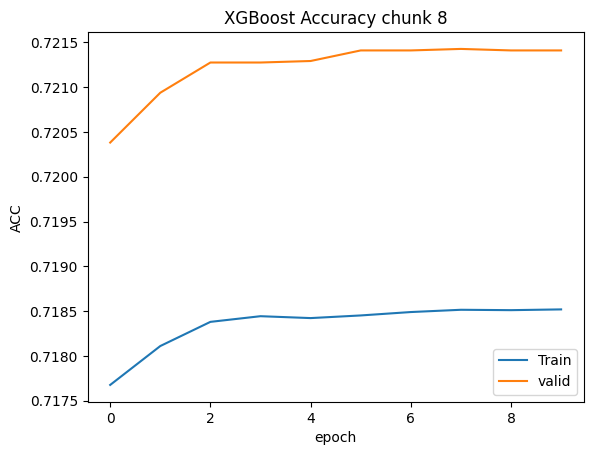

9
Accuracy: 60.21%
0.6306883799467059


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


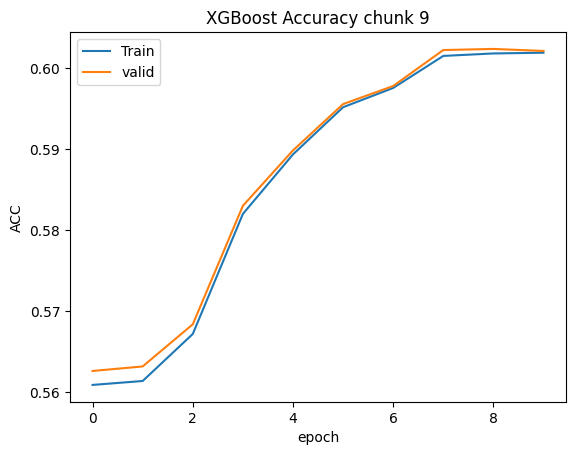

10
Accuracy: 68.91%
0.6365247624284672


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


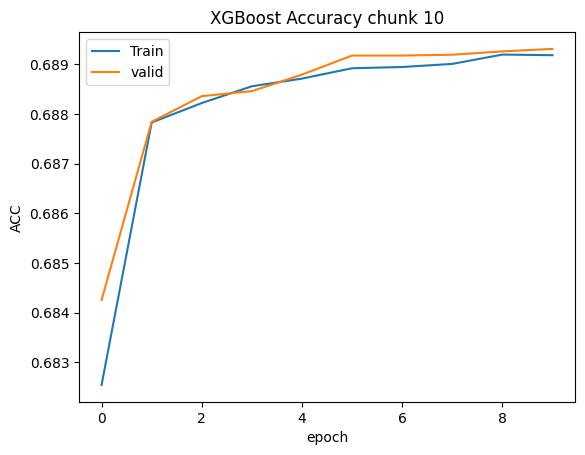

11
Accuracy: 70.40%
0.6426553464999348


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


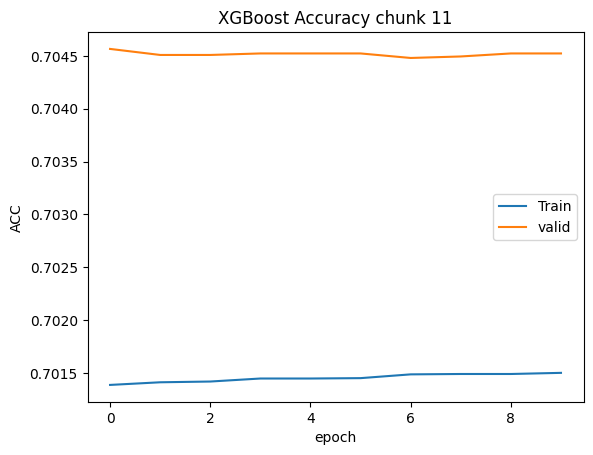

12
Accuracy: 61.57%
0.6404062007338139


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


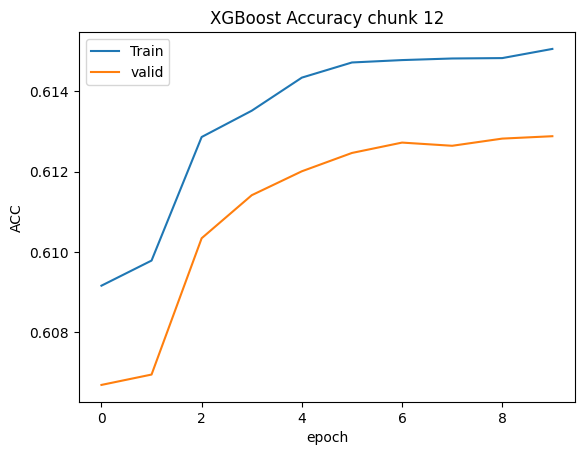

13
Accuracy: 79.42%
0.6522355757400409


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


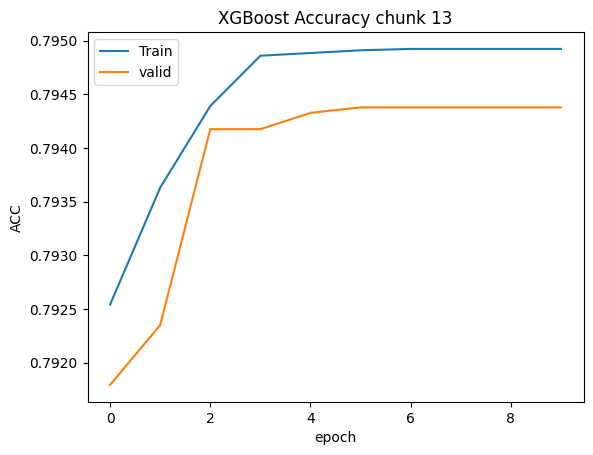

14
Accuracy: 77.43%
0.660951838994085


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


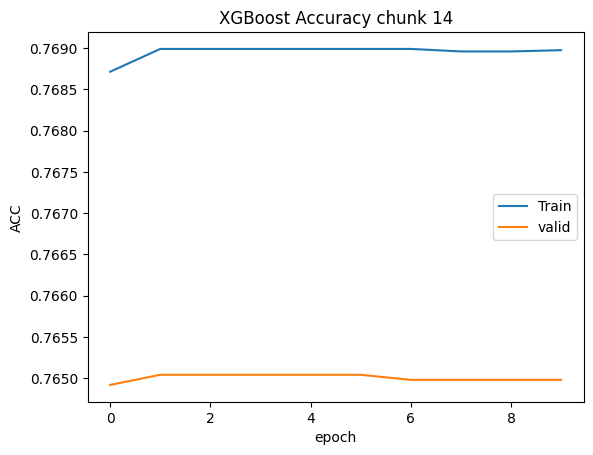

15
Accuracy: 53.72%
0.6527031059726431


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


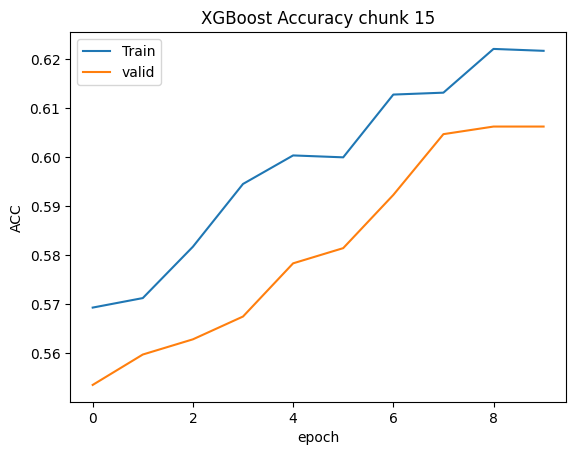

<ipython-input-45-9d03e64945cd>:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array(precisions),np.array(recalls),np.array(aucs)


In [ ]:
increamental_XGB_without_imputation = train_xgboost(df_list,y_df_list)

In [ ]:
increamental_XGB_without_imputation_results = {}
increamental_XGB_without_imputation_results['curves'] = increamental_XGB_without_imputation[0]
increamental_XGB_without_imputation_results['acc'] = increamental_XGB_without_imputation[1]
increamental_XGB_without_imputation_results['y_pred'] = increamental_XGB_without_imputation[2]
increamental_XGB_without_imputation_results['y_true'] = increamental_XGB_without_imputation[3]
increamental_XGB_without_imputation_results['f1'] = increamental_XGB_without_imputation[4]
increamental_XGB_without_imputation_results['precision'] = increamental_XGB_without_imputation[5]
increamental_XGB_without_imputation_results['recall'] = increamental_XGB_without_imputation[6]
increamental_XGB_without_imputation_results['auc'] = increamental_XGB_without_imputation[7]

with open('increamental_XGB_without_imputation_results.pkl', "wb") as file:
    pickle.dump(increamental_XGB_without_imputation_results, file)

!cp -r '/content/increamental_XGB_without_imputation_results.pkl' '/content/drive/MyDrive/Covid results'

In [ ]:
increamental_XGB_without_imputation_results['auc']

array([0.50933192, 0.5233056 , 0.51281248, 0.53235174, 0.52487053,
       0.51839912, 0.50266705, 0.50032346, 0.54444997, 0.50037078,
       0.50037208, 0.5164415 , 0.49997582, 0.50049082, 0.52173241])

In [ ]:
increamental_XGB_without_imputation_results['recall'].shape

(15,)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Masking
tf.random.set_seed(1)

def train_mlp(df_list, y_df_list, fs_masks=None,mask =True):
    acc = []
    f1s=[]
    precisions =[]
    recalls=[]
    aucs=[]
    # Create logistic regression model
    model = Sequential()
    if mask:
      model.add(Masking(mask_value=-1, input_shape=(df_list[0].shape[1],)))
      model.add(Dense(64, activation='relu'))
    else:
      model.add(Dense(64, activation='relu', input_shape=(df_list[0].shape[1],)))
    # input_dim is the number of features in your data
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    # num_classes is the number of classes in your classification problem
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    classifier = model
    # MLPClassifier(
    #       activation="relu",
    #       max_iter=100,
    #       validation_fraction=0.2,
    #       early_stopping=True,
    #       random_state=42,verbose=True)
    results = []
    y_pred = []
    y_true = []
    for i in range(len(df_list)):
        # Define your data and masks
        X = df_list[i].values
        # Define your labels
        y = y_df_list[i]
        if fs_masks is not None:
          print(X)
          X = np.where(np.array(fs_masks[i]) == 0, -1, X)
          print(fs_masks[i])
          print(X)
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        # if fs_masks is not None:
        #     masks_train = [fs_masks[i]] * len(X_train)
        #     masks_val = [fs_masks[i]] * len(X_val)
        #     masks_test = [fs_masks[i]] * len(X_test)

        #     # Apply masks to input data
        #     X_train_masked = X_train * masks_train
        #     X_val_masked = X_val * masks_val
        #     X_test_masked = X_test * masks_test
        # else:
        X_train_masked = X_train
        X_val_masked = X_val
        X_test_masked = X_test

        # # Convert masked data to sparse matrix
        # X_train_sparse = sparse.csr_matrix(X_train_masked)
        # X_val_sparse = sparse.csr_matrix(X_val_masked)
        # X_test_sparse = sparse.csr_matrix(X_test_masked)



        # Train logistic regression model on masked data
        history = classifier.fit(X_train_masked, y_train,validation_data=(X_val_masked,y_val),batch_size=int(X_train_masked.shape[0]*0.1),epochs=10,verbose=False)

        # print(mlp.score(X_train,y_train))


        # Make predictions on masked test data
        # preds = classifier.predict(X_test_masked)

        # Evaluate the accuracy of the model
        loss, accuracy = model.evaluate(X_test_masked, y_test)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
        acc.append(accuracy)
        print(np.mean(acc))
        preds = np.argmax(model.predict(X_test_masked), axis=-1)
        y_pred.append(preds)
        y_true.append(y_test)

        # Calculate F1 score
        f1 = f1_score(y_test, preds, average='weighted')
        f1s.append(f1)

        # Calculate precision
        precision = precision_score(y_test, preds, average='weighted')
        precisions.append(precision)

        # Calculate recall
        recall = recall_score(y_test, preds, average='weighted')
        recalls.append(recall)

        # Calculate AUC

        # Binarize the true labels
        y_true_binarized = label_binarize(y_test, classes=np.unique(y_test))

        # Calculate AUC for each class
        n_classes = len(np.unique(y_test))
        auc_scores = []

        for j in range(n_classes):
            y_true_j = y_true_binarized[:, j]     # True labels for class i
            y_pred_j = (preds == j).astype(int)  # Predicted labels for class i
            auc_j = roc_auc_score(y_true_j, y_pred_j)
            wighted_auc_j = ((preds==j).sum()/len(preds)) * auc_j
            auc_scores.append(auc_j)

        # Average the AUC scores
        mean_auc = np.mean(auc_scores)
        aucs.append(mean_auc)

        # Plot accuracy over epochs
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Logistic Regression Accuracy chunk {i+1}')
        plt.show()
        results.append((history.history['accuracy'],history.history['val_accuracy']))
    return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array(precisions),np.array(recalls),np.array(aucs)

# increamental_NN_without_imputation



8/8 [==============================] - 0s 3ms/step - loss: 0.4391 - accuracy: 0.8770
Accuracy: 87.70%
0.8770492076873779
8/8 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


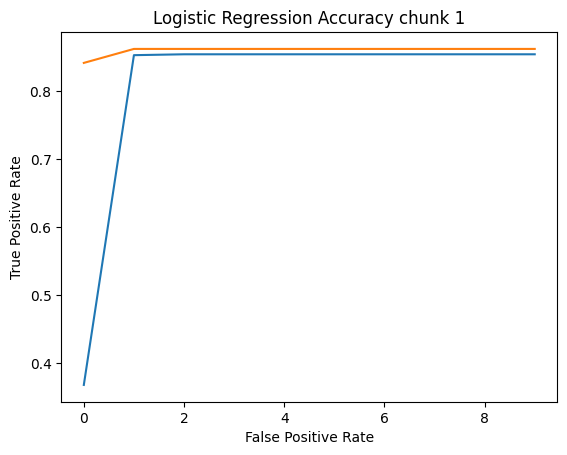

892/892 [==============================] - 3s 4ms/step - loss: 1.0794 - accuracy: 0.4488
Accuracy: 44.88%
0.6629464626312256
892/892 [==============================] - 4s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


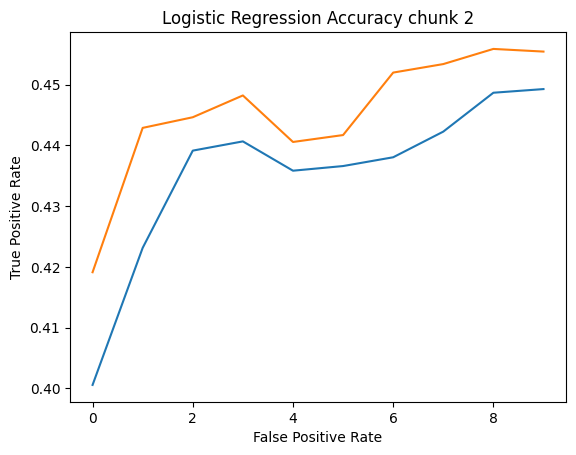

1694/1694 [==============================] - 7s 4ms/step - loss: 0.9542 - accuracy: 0.5685
Accuracy: 56.85%
0.6314794222513834
1694/1694 [==============================] - 5s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


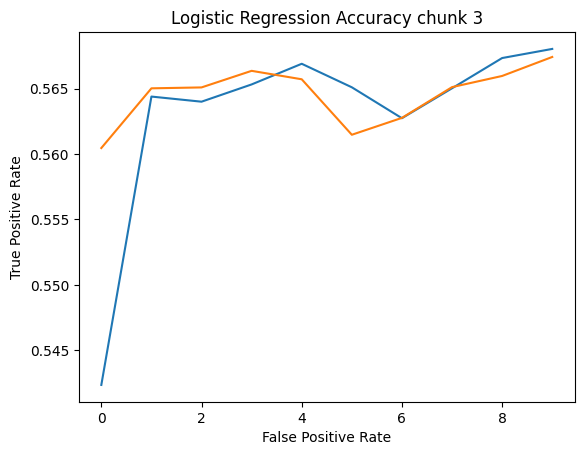

2466/2466 [==============================] - 7s 3ms/step - loss: 0.9403 - accuracy: 0.5609
Accuracy: 56.09%
0.6138390153646469
2466/2466 [==============================] - 7s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


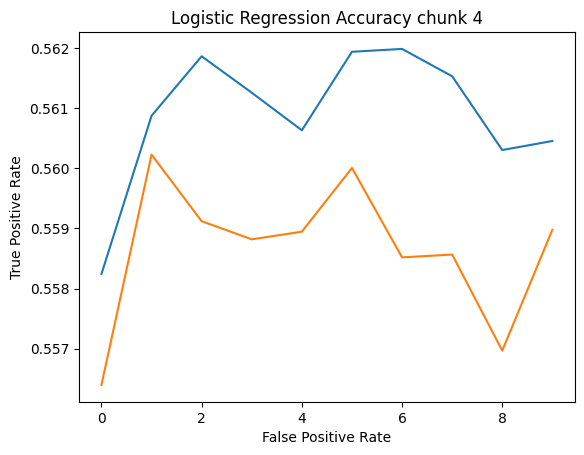

2363/2363 [==============================] - 5s 2ms/step - loss: 0.9573 - accuracy: 0.5400
Accuracy: 54.00%
0.5990776658058167
2363/2363 [==============================] - 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


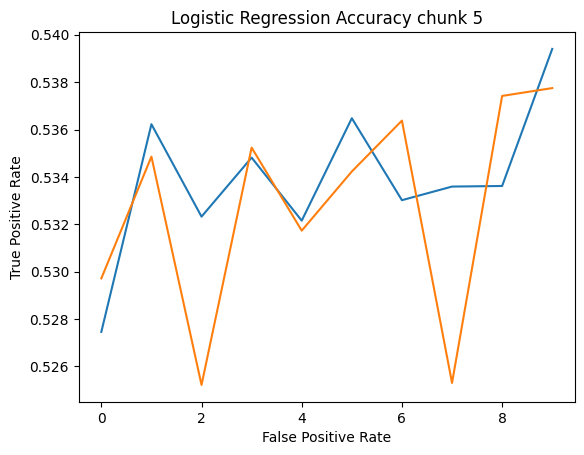

2675/2675 [==============================] - 5s 2ms/step - loss: 0.8990 - accuracy: 0.6088
Accuracy: 60.88%
0.6007035275300344
2675/2675 [==============================] - 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


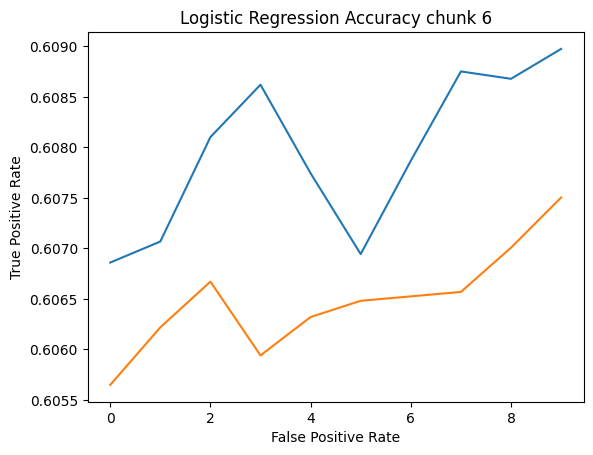

2759/2759 [==============================] - 5s 2ms/step - loss: 0.7107 - accuracy: 0.7486
Accuracy: 74.86%
0.6218313063894
2759/2759 [==============================] - 6s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


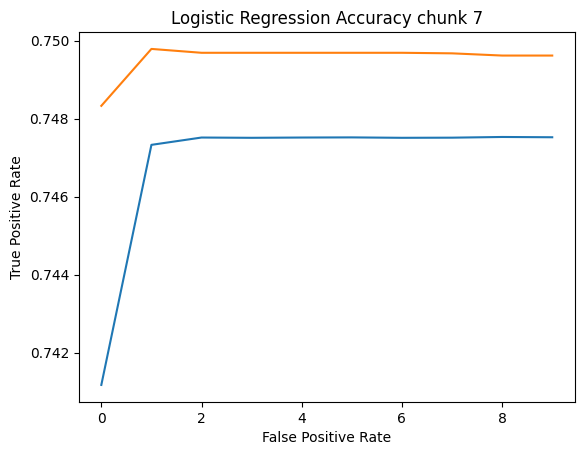

2317/2317 [==============================] - 4s 2ms/step - loss: 0.8329 - accuracy: 0.7192
Accuracy: 71.92%
0.6340037286281586
2317/2317 [==============================] - 5s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


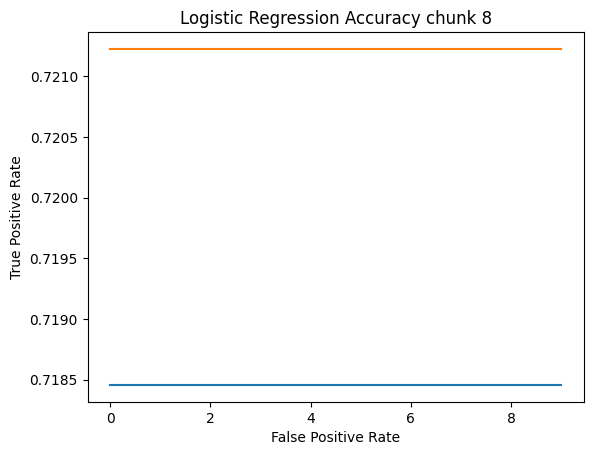

6774/6774 [==============================] - 13s 2ms/step - loss: 0.8757 - accuracy: 0.5999
Accuracy: 59.99%
0.6302157971594069
6774/6774 [==============================] - 12s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


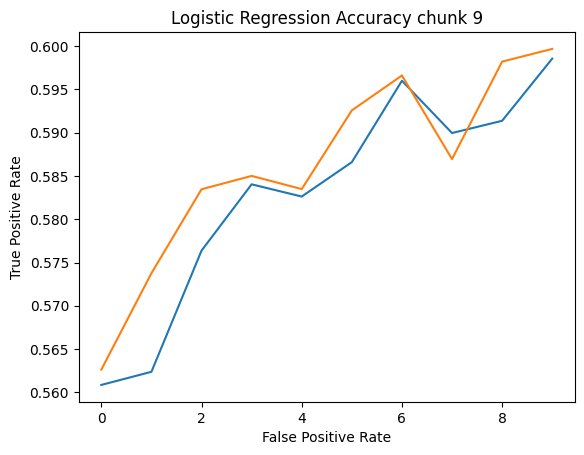

2343/2343 [==============================] - 4s 2ms/step - loss: 0.8582 - accuracy: 0.6891
Accuracy: 68.91%
0.6361061096191406
2343/2343 [==============================] - 5s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


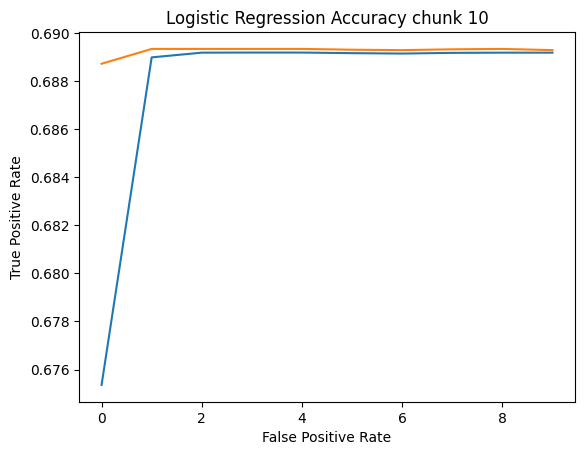

2738/2738 [==============================] - 5s 2ms/step - loss: 0.8273 - accuracy: 0.7040
Accuracy: 70.40%
0.6422747536139055
2738/2738 [==============================] - 7s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


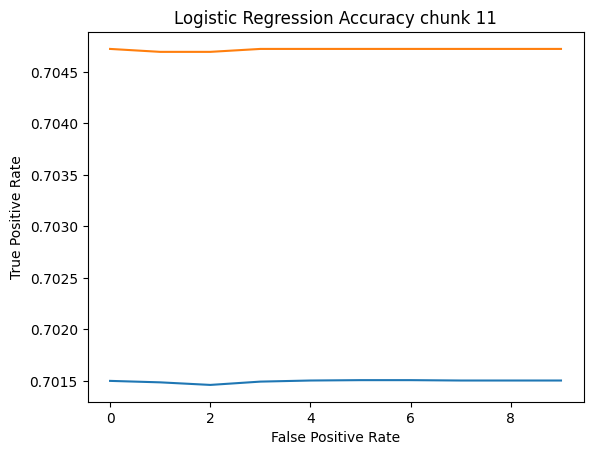

1968/1968 [==============================] - 4s 2ms/step - loss: 0.9021 - accuracy: 0.6120
Accuracy: 61.20%
0.63975557188193
1968/1968 [==============================] - 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


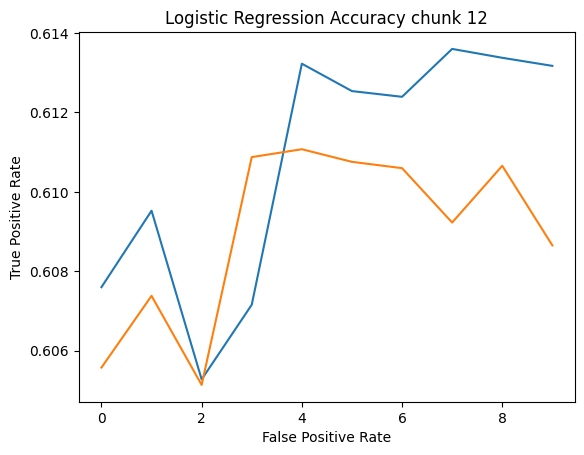

770/770 [==============================] - 2s 2ms/step - loss: 0.6986 - accuracy: 0.7943
Accuracy: 79.43%
0.6516412404867319
770/770 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


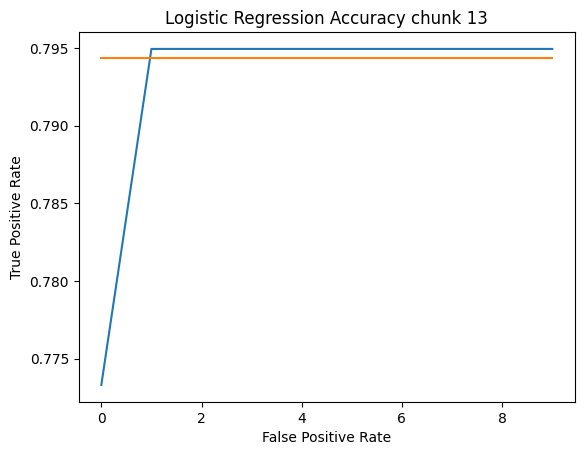

637/637 [==============================] - 1s 2ms/step - loss: 0.7551 - accuracy: 0.7741
Accuracy: 77.41%
0.6603894318853106
637/637 [==============================] - 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


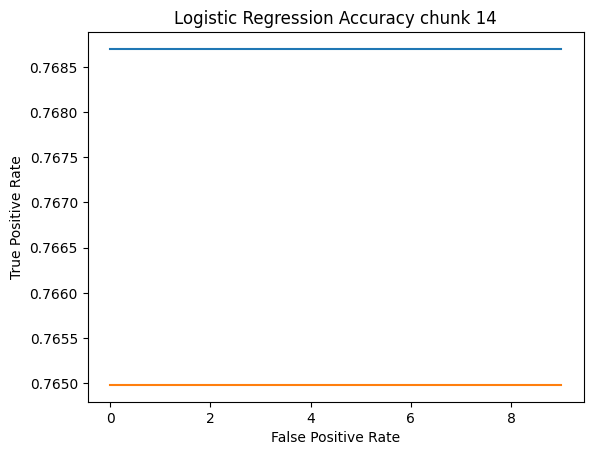

26/26 [==============================] - 0s 2ms/step - loss: 0.9207 - accuracy: 0.5372
Accuracy: 53.72%
0.6521781921386719
26/26 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


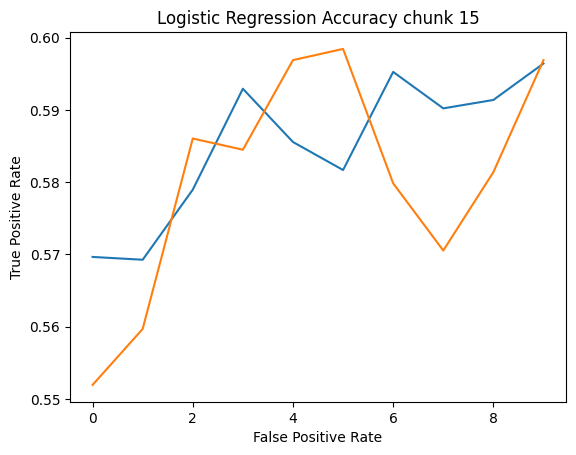

<ipython-input-57-4b8f5d594426>:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array(precisions),np.array(recalls),np.array(aucs)


In [ ]:
increamental_NN_without_imputation = train_mlp(df_list,y_df_list,mask = False)

In [ ]:
increamental_NN_without_imputation_results = {}
increamental_NN_without_imputation_results['curves'] = increamental_NN_without_imputation[0]
increamental_NN_without_imputation_results['acc'] = increamental_NN_without_imputation[1]
increamental_NN_without_imputation_results['y_pred'] = increamental_NN_without_imputation[2]
increamental_NN_without_imputation_results['y_true'] = increamental_NN_without_imputation[3]
increamental_NN_without_imputation_results['f1'] = increamental_NN_without_imputation[4]
increamental_NN_without_imputation_results['precision'] = increamental_NN_without_imputation[5]
increamental_NN_without_imputation_results['recall'] = increamental_NN_without_imputation[6]
increamental_NN_without_imputation_results['auc'] = increamental_NN_without_imputation[7]

with open('increamental_NN_without_imputation_results.pkl', "wb") as file:
    pickle.dump(increamental_NN_without_imputation_results, file)

!cp -r '/content/increamental_NN_without_imputation_results.pkl' '/content/drive/MyDrive/Covid results'

# increamental_NN_with_mask_imputation

8/8 [==============================] - 0s 3ms/step - loss: 0.4356 - accuracy: 0.8852
Accuracy: 88.52%
0.8852459192276001
8/8 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


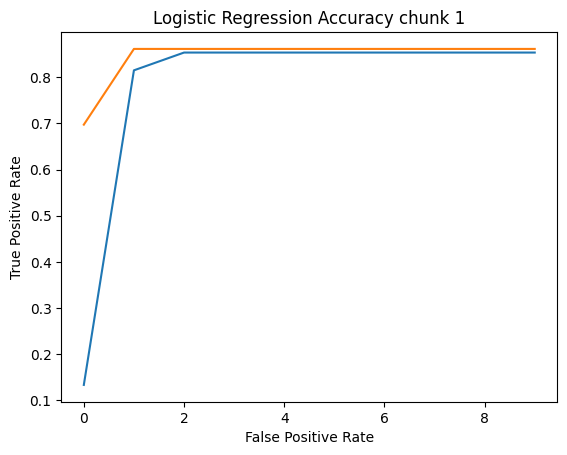

892/892 [==============================] - 2s 2ms/step - loss: 1.0785 - accuracy: 0.4498
Accuracy: 44.98%
0.6675279289484024
892/892 [==============================] - 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


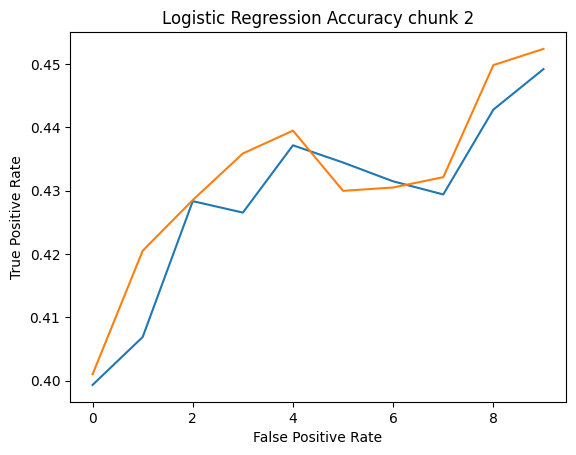

1694/1694 [==============================] - 4s 2ms/step - loss: 0.9579 - accuracy: 0.5639
Accuracy: 56.39%
0.6329722901185354
1694/1694 [==============================] - 2s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


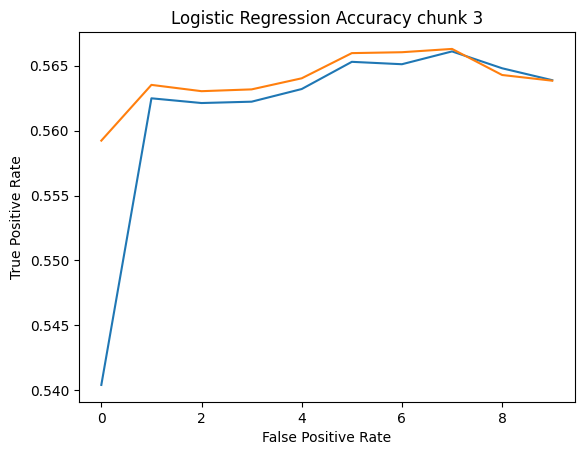

2466/2466 [==============================] - 6s 2ms/step - loss: 0.9409 - accuracy: 0.5626
Accuracy: 56.26%
0.6153896674513817
2466/2466 [==============================] - 4s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


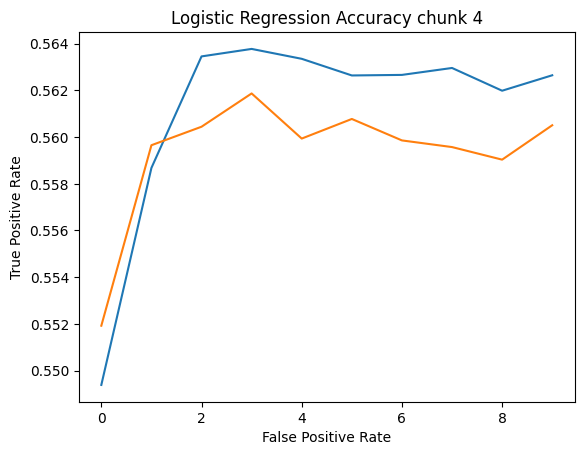

2363/2363 [==============================] - 4s 2ms/step - loss: 0.9555 - accuracy: 0.5423
Accuracy: 54.23%
0.60076784491539
2363/2363 [==============================] - 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


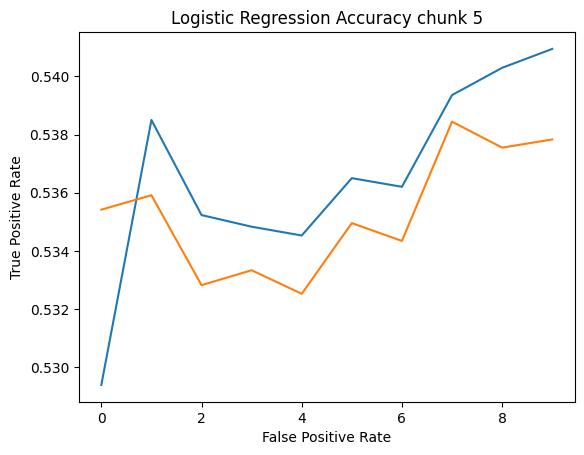

2675/2675 [==============================] - 6s 2ms/step - loss: 0.8987 - accuracy: 0.6069
Accuracy: 60.69%
0.6017848600943884
2675/2675 [==============================] - 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


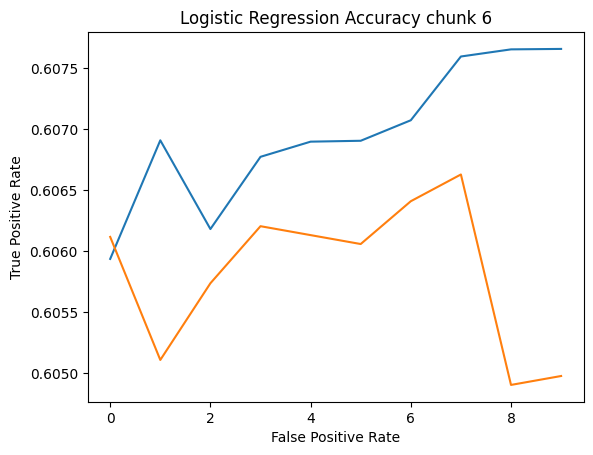

2759/2759 [==============================] - 6s 2ms/step - loss: 0.7096 - accuracy: 0.7486
Accuracy: 74.86%
0.6227581628731319
2759/2759 [==============================] - 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


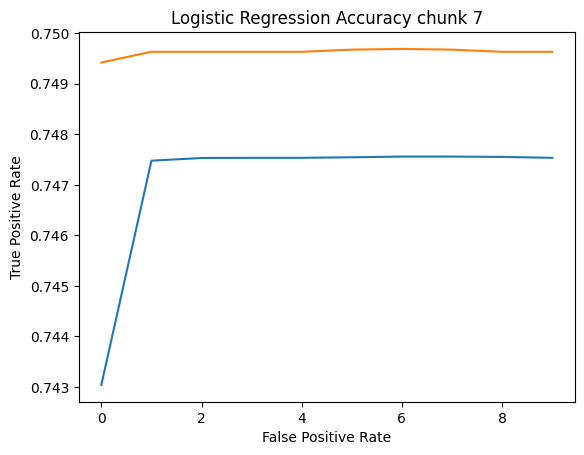

2317/2317 [==============================] - 4s 2ms/step - loss: 0.8331 - accuracy: 0.7192
Accuracy: 71.92%
0.634814728051424
2317/2317 [==============================] - 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


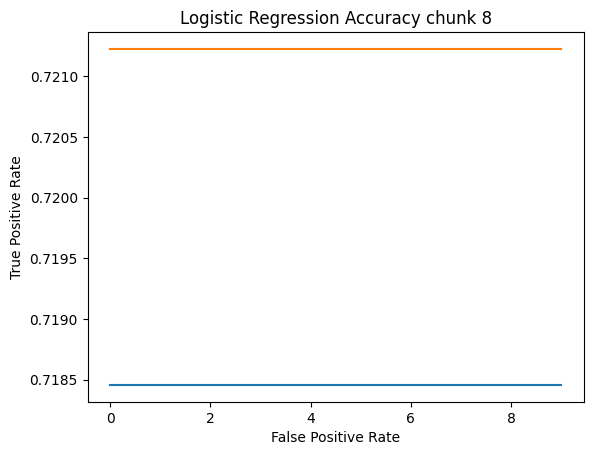

6774/6774 [==============================] - 14s 2ms/step - loss: 0.8772 - accuracy: 0.5939
Accuracy: 59.39%
0.6302651663621267
6774/6774 [==============================] - 11s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


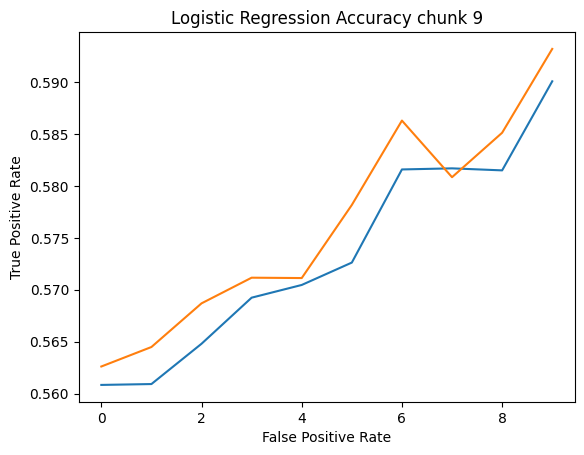

2343/2343 [==============================] - 4s 2ms/step - loss: 0.8570 - accuracy: 0.6892
Accuracy: 68.92%
0.6361612111330033
2343/2343 [==============================] - 5s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


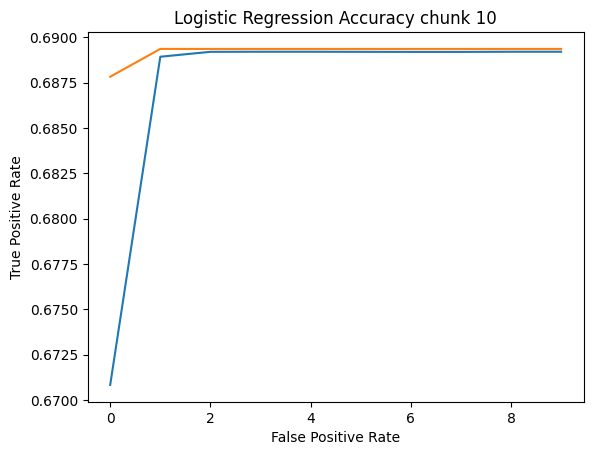

2738/2738 [==============================] - 6s 2ms/step - loss: 0.8262 - accuracy: 0.7040
Accuracy: 70.40%
0.6423258808526126
2738/2738 [==============================] - 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


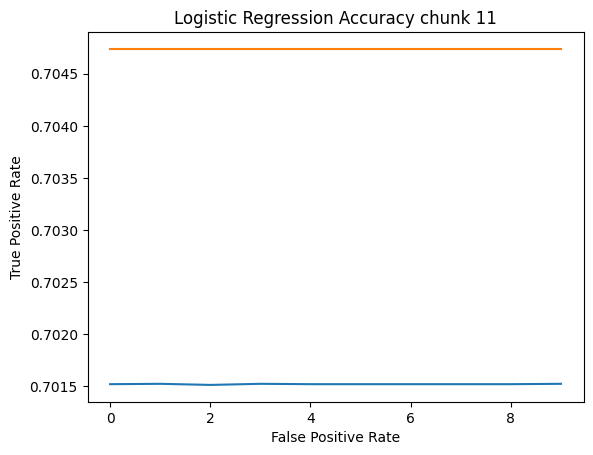

1968/1968 [==============================] - 4s 2ms/step - loss: 0.9022 - accuracy: 0.6109
Accuracy: 61.09%
0.6397045031189919
1968/1968 [==============================] - 4s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


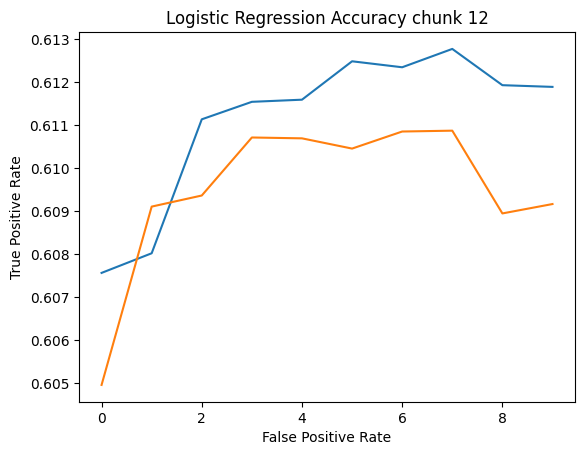

770/770 [==============================] - 1s 2ms/step - loss: 0.6976 - accuracy: 0.7943
Accuracy: 79.43%
0.6515941000901736
770/770 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


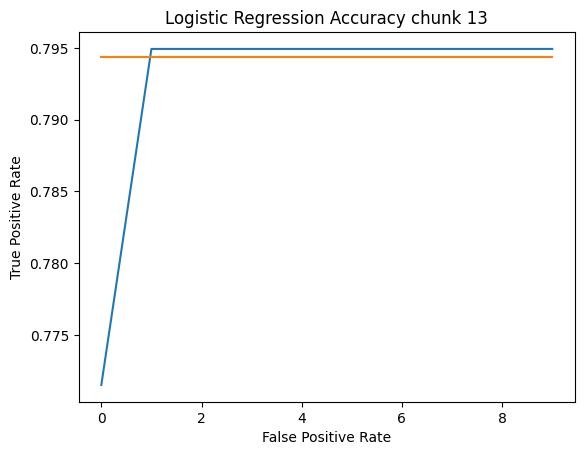

637/637 [==============================] - 1s 2ms/step - loss: 0.7552 - accuracy: 0.7741
Accuracy: 77.41%
0.660345658659935
637/637 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


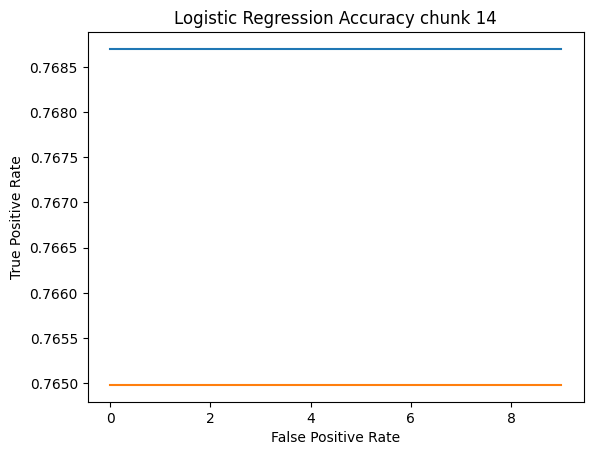

26/26 [==============================] - 0s 2ms/step - loss: 0.9229 - accuracy: 0.5447
Accuracy: 54.47%
0.6526336173216502
26/26 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


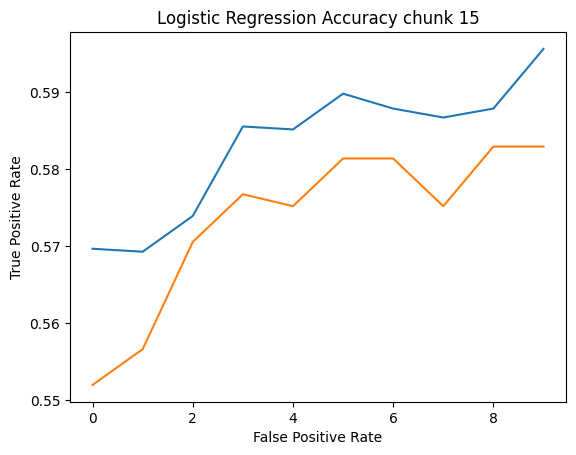

<ipython-input-57-4b8f5d594426>:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results) , np.array(acc) ,np.array(y_pred),np.array(y_true),np.array(f1s),np.array(precisions),np.array(recalls),np.array(aucs)


In [ ]:
increamental_NN_with_mask_imputation = train_mlp(df_list,y_df_list)

In [ ]:
increamental_NN_with_mask_imputation_results = {}
increamental_NN_with_mask_imputation_results['curves'] = increamental_NN_with_mask_imputation[0]
increamental_NN_with_mask_imputation_results['acc'] = increamental_NN_with_mask_imputation[1]
increamental_NN_with_mask_imputation_results['y_pred'] = increamental_NN_with_mask_imputation[2]
increamental_NN_with_mask_imputation_results['y_true'] = increamental_NN_with_mask_imputation[3]
increamental_NN_with_mask_imputation_results['f1'] = increamental_NN_with_mask_imputation[4]
increamental_NN_with_mask_imputation_results['precision'] = increamental_NN_with_mask_imputation[5]
increamental_NN_with_mask_imputation_results['recall'] = increamental_NN_with_mask_imputation[6]
increamental_NN_with_mask_imputation_results['auc'] = increamental_NN_with_mask_imputation[7]

with open('increamental_NN_with_mask_imputation_results.pkl', "wb") as file:
    pickle.dump(increamental_NN_with_mask_imputation_results, file)

!cp -r '/content/increamental_NN_with_mask_imputation_results.pkl' '/content/drive/MyDrive/Covid results'